In [1]:

import jax.random as jr
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
from jax import Array

from dynamax.linear_gaussian_ssm import lgssm_filter
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from feynman_kac.protocol import FeynmacKac, PFConfig, PFOutputs
from feynman_kac.bootstrap import BPF, ConditionalBPF
from feynmanc_kac.model.lgssm import LGSSMModel

from resample.backward_sampling import LineageTracking
from utils.datasets import load_dataset

In [16]:
import inspect

methods = inspect.getmembers(ConditionalBPF, predicate=inspect.isfunction)
parent = inspect.getmro(ConditionalBPF)
print(methods) # Output: [('method1', <function MyClass.method1>),
print(parent)

[('__init__', <function ConditionalBPF.__init__ at 0x70d0fc1bdd00>), ('filter', <function BaseParticleFilter.filter at 0x70d0fc1bd6c0>), ('step', <function ConditionalBPF.step at 0x70d0fc1bde40>), ('t0', <function ConditionalBPF.t0 at 0x70d0fc1bdda0>), ('update_params', <function BaseParticleFilter.update_params at 0x70d0fc1bd8a0>)]
(<class 'feynman_kac.bootstrap.ConditionalBPF'>, <class 'feynman_kac.bootstrap.BaseParticleFilter'>, <class 'abc.ABC'>, <class 'object'>)


In [2]:

def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior


def bpf(key: jr.PRNGKey, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = BPF(
        model=lgssm,
        cfg=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key=key,
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs

def csmc(key, data, N: int, bpf_outs: PFOutputs):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)

    csmc = ConditionalBPF(
        model=lgssm,
        cfg=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    ref = LineageTracking.sample(
        key=jr.PRNGKey(9919),
        model=lgssm,
        particles=bpf_outs.particles,
        ancestors=bpf_outs.ancestors,
        weights=bpf_outs.weights
    )
    print(ref.shape)
    outs = csmc.filter(
        key=key,
        obs=data.train_data[0][0],  # just using the first sequence
        ref=ref
    )
    print("CSMC particles shape: ", outs.particles.shape)
    print("CSMC weights shape: ", outs.weights.shape)
    print("CSMC logZ_hat: ", outs.logZ_hat)
    return outs

In [3]:
data = load_dataset('linear_small', seed=0)
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 1)


In [4]:
data.params

{'m1': Array([0.], dtype=float32),
 'Q1': Array([[1.]], dtype=float32),
 'A': Array([[0.7324345]], dtype=float32),
 'b': Array([0.], dtype=float32),
 'Q': Array([[0.46353966]], dtype=float32),
 'R': Array([[0.31622776]], dtype=float32),
 'C': Array([[0.4194783]], dtype=float32),
 'd': Array([-0.6027049], dtype=float32)}

In [5]:
N = 50
print(f"N: {N:<-100}")
key = jr.PRNGKey(1010)
outs = bpf(key, data, N)

N: 50                                                                                                  
BPF particles shape:  (300, 50, 1)
BPF weights shape:  (300, 50)
BPF logZ_hat:  -737.3803


In [6]:
outs.weights.shape, outs.ancestors.shape, outs.particles.shape

((300, 50), (299, 50), (300, 50, 1))

N: 10                                                                                                  
BPF particles shape:  (300, 10, 1)
BPF weights shape:  (300, 10)
BPF logZ_hat:  -910.0794
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.18982877


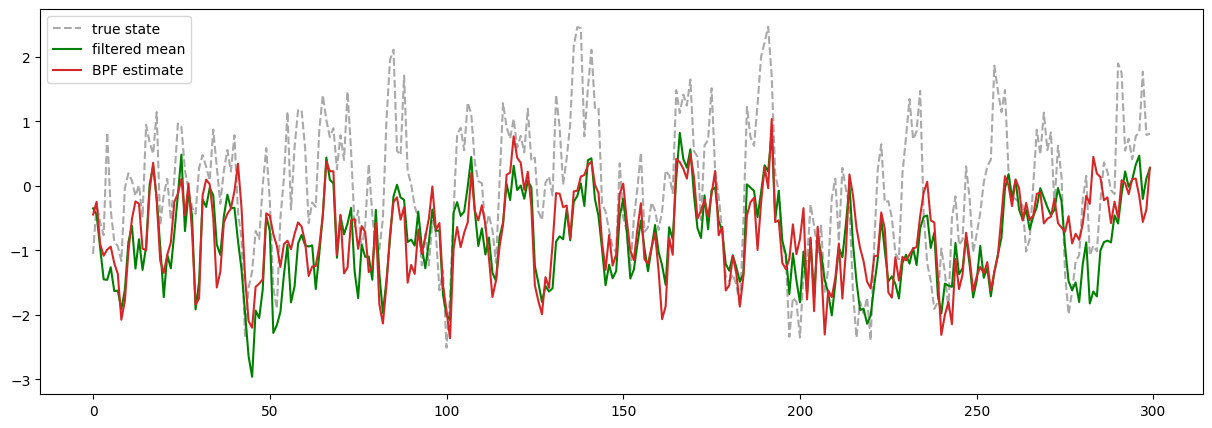




N: 50                                                                                                  
BPF particles shape:  (300, 50, 1)
BPF weights shape:  (300, 50)
BPF logZ_hat:  -744.0678
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.016625002


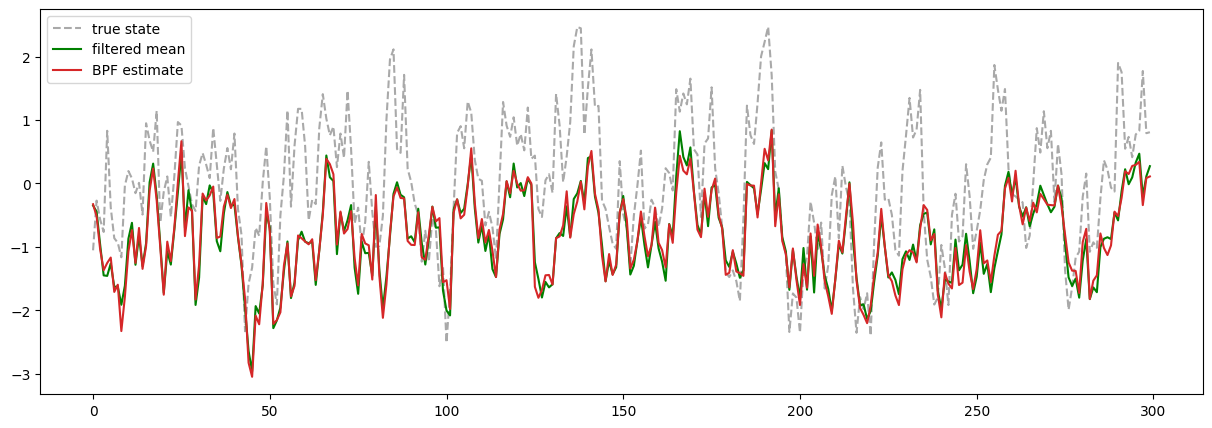




N: 200                                                                                                 
BPF particles shape:  (300, 200, 1)
BPF weights shape:  (300, 200)
BPF logZ_hat:  -721.20374
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.0074627623


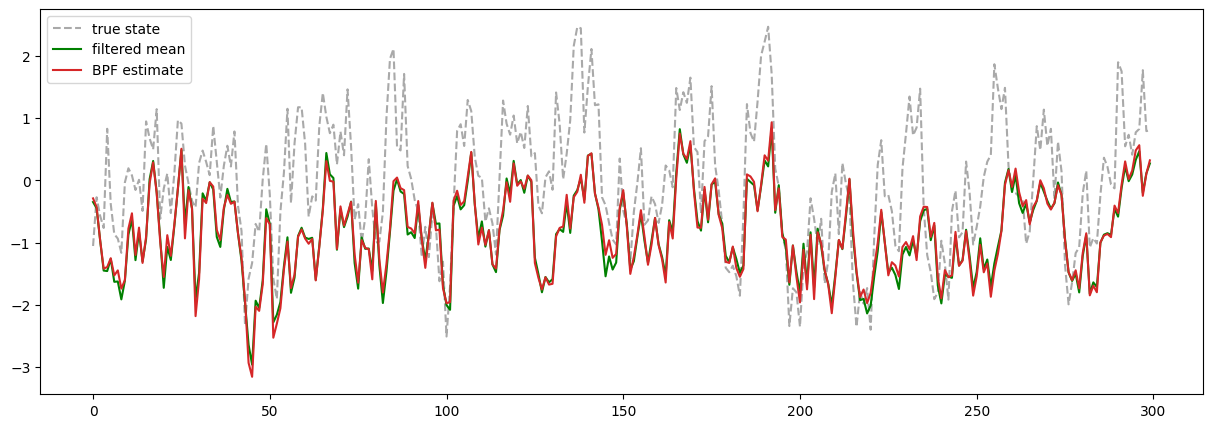

In [7]:
for N in [10, 50, 200]:
    print(f"N: {N:<-100}")
    outs = bpf(jr.PRNGKey(N), data, N)
    
    # calculate weighted estimates of state means
    x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
    print("BPF weighted x_t shape: ", x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from BPF to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(x_hat[:, 3], color="tab:red", label="BPF estimate")
    plt.legend()
    plt.show()
    print("\n\n")

In [8]:
N = 50
print(f"N: {N:<-100}")
key = jr.PRNGKey(1010)
csmc_outs = csmc(key, data, N, outs)

N: 50                                                                                                  
(300, 1)
CSMC particles shape:  (300, 50, 1)
CSMC weights shape:  (300, 50)
CSMC logZ_hat:  -741.60913


In [9]:
csmc_outs.weights.shape

(300, 50)

N: 10                                                                                                  
(300, 1)
CSMC particles shape:  (300, 10, 1)
CSMC weights shape:  (300, 10)
CSMC logZ_hat:  -868.153
CSMC weighted x_t shape:  (300, 1)
MSE from CSMC to exact filter means:  0.100449756


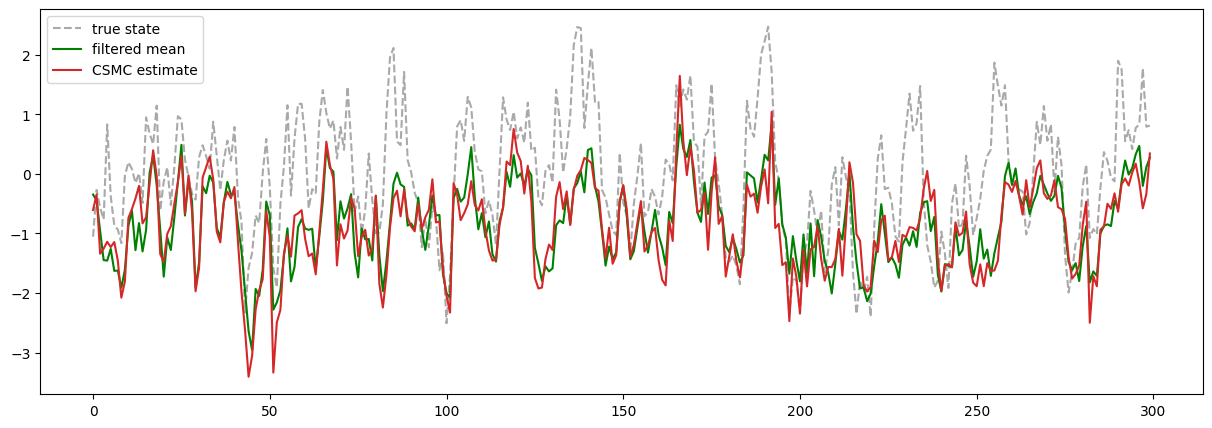




N: 50                                                                                                  
(300, 1)
CSMC particles shape:  (300, 50, 1)
CSMC weights shape:  (300, 50)
CSMC logZ_hat:  -742.8272
CSMC weighted x_t shape:  (300, 1)
MSE from CSMC to exact filter means:  0.025737986


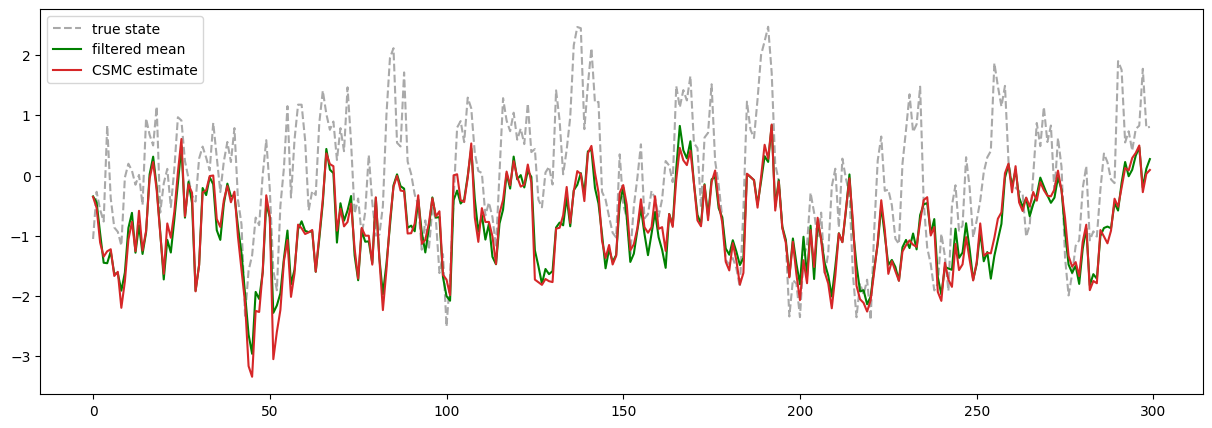




N: 200                                                                                                 
(300, 1)
CSMC particles shape:  (300, 200, 1)
CSMC weights shape:  (300, 200)
CSMC logZ_hat:  -703.5527
CSMC weighted x_t shape:  (300, 1)
MSE from CSMC to exact filter means:  0.010098777


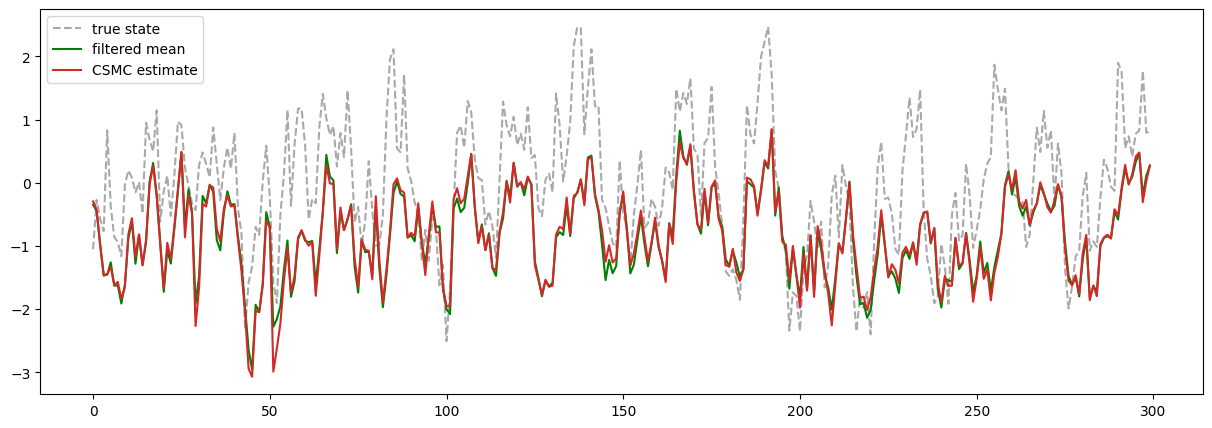

In [10]:
for N in [10, 50, 200]:
    print(f"N: {N:<-100}")
    csmc_outs = csmc(jr.PRNGKey(N), data, N, outs)
    
    # calculate weighted estimates of state means
    x_hat = jnp.sum(csmc_outs.weights[:, :, None] * csmc_outs.particles, axis=1)
    print("CSMC weighted x_t shape: ", x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from CSMC to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(x_hat[:, 3], color="tab:red", label="CSMC estimate")
    plt.legend()
    plt.show()
    print("\n\n")

In [ ]:

# def csmc_bpf(data, N: int):

#     lgssm = LGSSMModel(data.params)
#     T = data.train_data[0].shape[1]
#     obs = data.train_data[0][0]  # just use the first sequence

#     # run a single particle through BPF to get immortal trajectory
#     bpf = BootstrapParticleFilter(
#         model=lgssm,
#         config=PFConfig(
#             N=1,
#             resample_scheme='multinomial',
#             ess_threshold=0.5,
#             key=jr.PRNGKey(42)
#         )
#     )
#     bpf_outs = bpf.filter(T=T, obs=obs)
#     x_imm = bpf_outs.particles[:, 0]
#     print(x_imm.shape)
    
#     # same config as regular BPF
#     csmc = ConditionalBPF(
#         model=lgssm,
#         config=PFConfig(
#             N=N,
#             resample_scheme='multinomial',
#             ess_threshold=0.5,
#             key=jr.PRNGKey(42)
#         )
#     )
#     csmc_outs = csmc.csmc(T=T, obs=obs, x_imm=x_imm)
    
#     print("CSMC particles shape: ", csmc_outs.particles.shape)
#     print("CSMC weights shape: ", csmc_outs.weights.shape)
#     print("CSMC logZ_hat: ", csmc_outs.logZ_hat)
#     return x_imm, csmc_outs 